In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from tqdm.auto import tqdm
import sys
import glob
# import cmasher as cmr
from matplotlib import cm
import matplotlib as mpl

In [79]:
sys.path.append("/Users/pnr5sh/Documents/phd/mmmp/")
import sidchaini.sidhelpers as sidhelpers

In [120]:
#reading in meta data from sid's dir
header = ['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC', 'Obj. Type',
          'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)', 'From', 'Telescope',
          'Instrument', 'Observer/s', 'Reducer/s', 'Source group', 'Public', 'Associated groups',
          'End prop. period', 'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
          'Extinction-Corrected', 'WL Medium','WL Units', 'Flux Unit Coefficient', 'Spec. units',
          'Flux Calibrated By', 'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
          'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib', 'Publish', 'Remarks',
          'Created by', 'Creation date']
all_spec_meta = pd.read_csv('../sidchaini/1. download ALL wise data/wiserep_spectra_combined.csv', header='infer')
all_spec_meta.columns

Index(['wise_objid', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [121]:
#unique objs in all wiserep spec
all_spec_meta['Obj. Type'].unique()

array(['SN Ia', 'SN II', 'SN Ib', 'SN IIn', 'SN Ib/c', 'Other', 'M dwarf',
       'SN Ic-BL', 'SN IIP', 'SLSN-R', 'SN I-rapid', 'Varstar', 'Galaxy',
       'SLSN-I', 'SN Ic', 'SN IIL', 'SN Ia-pec', 'CV', 'SN Ia-91T-like',
       'SN IIb', 'LBV', 'SN IIn-pec', nan, 'WR-WN', 'SN Ia-CSM',
       'SN Ia-91bg-like', 'SN II-pec', 'SN', 'SN Iax[02cx-like]',
       'SN Ic-Ca-rich', 'TDE', 'SN Ibn', 'Gap', 'AGN', 'SN Ib-pec',
       'SLSN-II', 'SN I', 'ILRT', 'Nova', 'Impostor-SN', 'Computed-PISN',
       'WR-WC', 'Computed-IIP', 'Std-spec', 'TDE-He', 'SN Ia-Ca-rich',
       'Computed-Ia', 'SN Ib-Ca-rich', 'SN Ic-pec', 'SN Ia-SC',
       'SN Ib/c-Ca-rich', 'LRN', 'Computed-IIb', 'Afterglow', 'QSO',
       'Kilonova', 'SN Icn', 'Computed-IIn', 'Light-Echo', 'FBOT',
       'SN Ien', 'SN Ibn/Icn', 'FRB', 'TDE-H-He', 'Blazar', 'NA/Unknown'],
      dtype=object)

In [123]:
all_spec_meta['mjd'] = all_spec_meta['JD']-2400000.5

In [124]:
# filters for specific types
multi_types = (all_spec_meta['Obj. Type']=='SN IIb')|(all_spec_meta['Obj. Type']=='SN Ib')|(all_spec_meta['Obj. Type']=='SN Ic')|(all_spec_meta['Obj. Type']=='SLSN-I')|(all_spec_meta['Obj. Type']=='SLSN-II')|(all_spec_meta['Obj. Type']=='SN IIn')

#filters for ZTF/P60 data
p60 = (all_spec_meta['Telescope']=='P60')
sedm = (all_spec_meta['Instrument']=='SEDM')

In [ ]:
# creating df of only objects meeting our target types, from ZTF 
mp_spec_df = all_spec_meta.loc[multi_types&p60&sedm]
print('No. of Unique Objs =', len(mp_spec_df['IAU name'].unique()))

#converting redshifts to floats
# pd.to_numeric(mp_spec_df['Redshift'], errors='coerce')

No. of Unique Objs = 212


In [145]:
#defining specific type filters for the subselected df
iib = (mp_spec_df['Obj. Type']=='SN IIb')
ib = (mp_spec_df['Obj. Type']=='SN Ib')
ic = (mp_spec_df['Obj. Type']=='SN Ic')
slsni = (mp_spec_df['Obj. Type']=='SLSN-I')
slsnii = (mp_spec_df['Obj. Type']=='SLSN-II')
iin = (mp_spec_df['Obj. Type']=='SN IIn')

#defining specific type filters for the big dataframe
# iib = (all_spec_meta['Obj. Type']=='SN IIb')
# ib = (all_spec_meta['Obj. Type']=='SN Ib')
# ic = (all_spec_meta['Obj. Type']=='SN Ic')
# slsni = (all_spec_meta['Obj. Type']=='SLSN-I')
# slsnii = (all_spec_meta['Obj. Type']=='SLSN-II')
# iin = (all_spec_meta['Obj. Type']=='SN IIn')

In [126]:
#just testing that we can plot the spectra

# for i in range(len(X)):
#     plt.figure()
#     plt.plot(wavelengths, X[i])
#     plt.xlabel('wavelength [A]')
#     plt.ylabel('normalized flux')
#     plt.title(f'{obj_names[i]}')

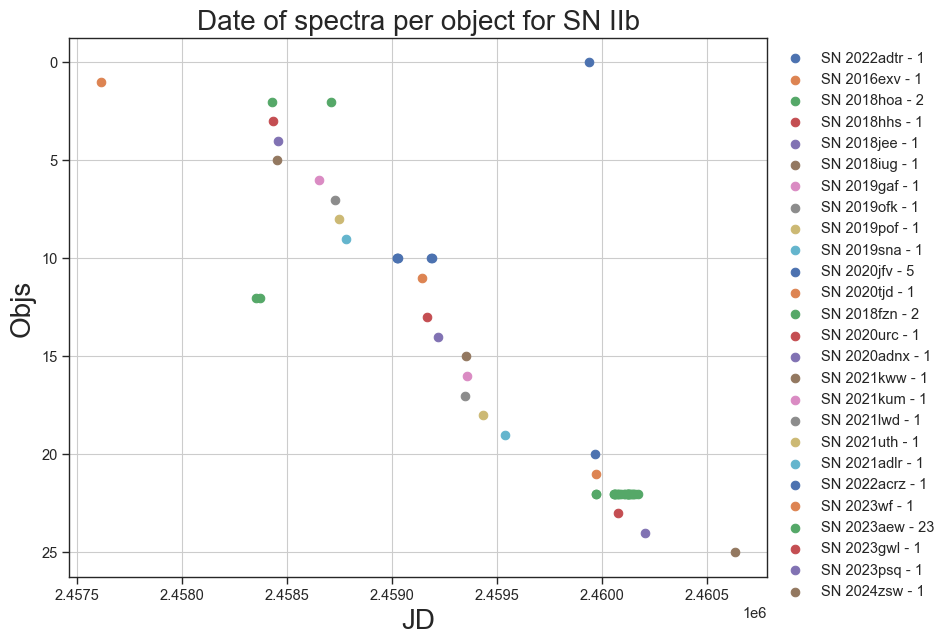

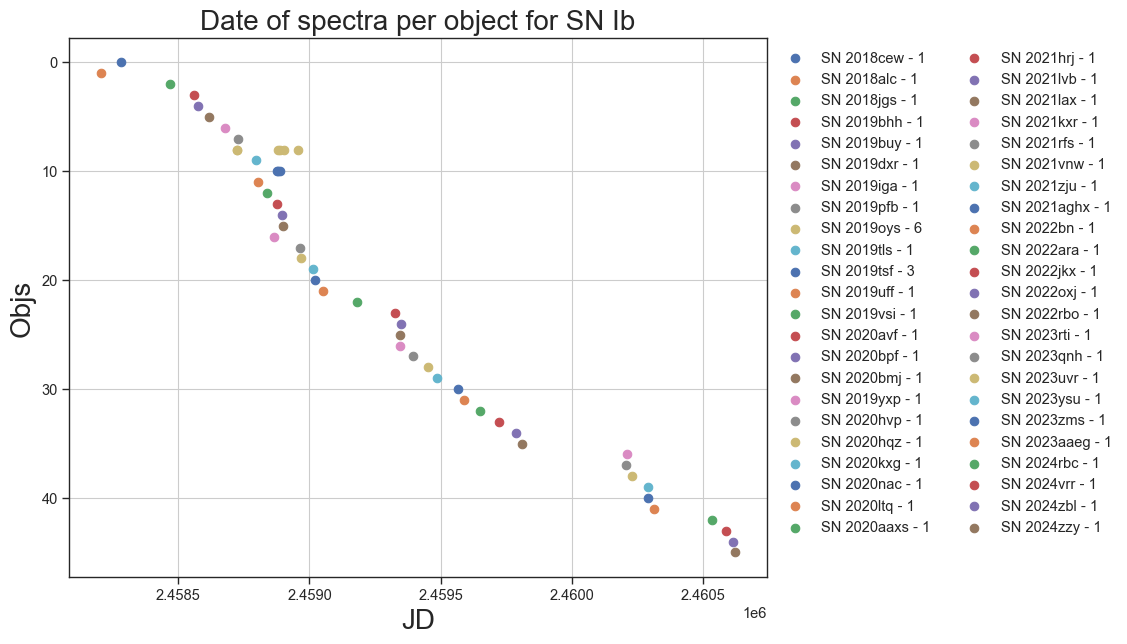

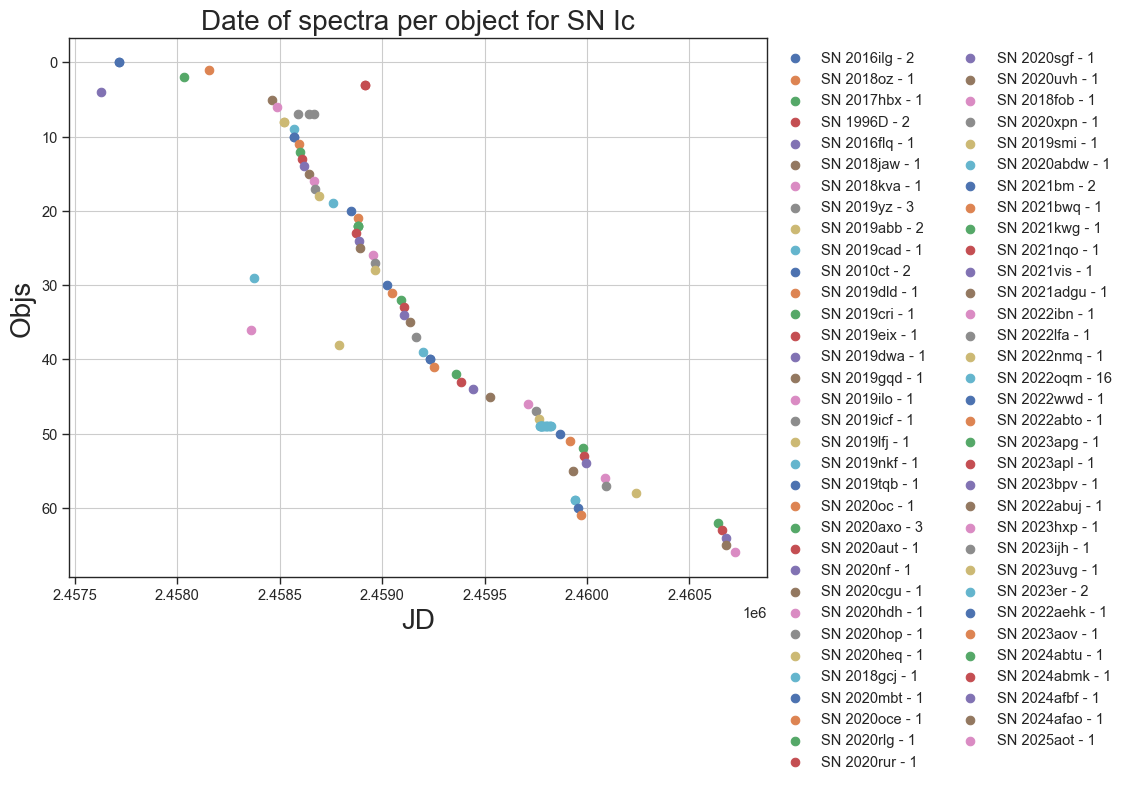

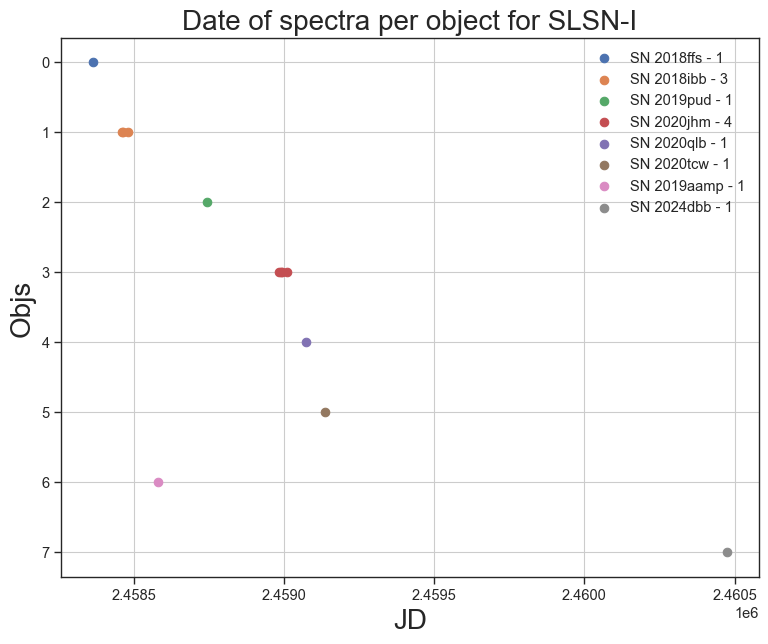

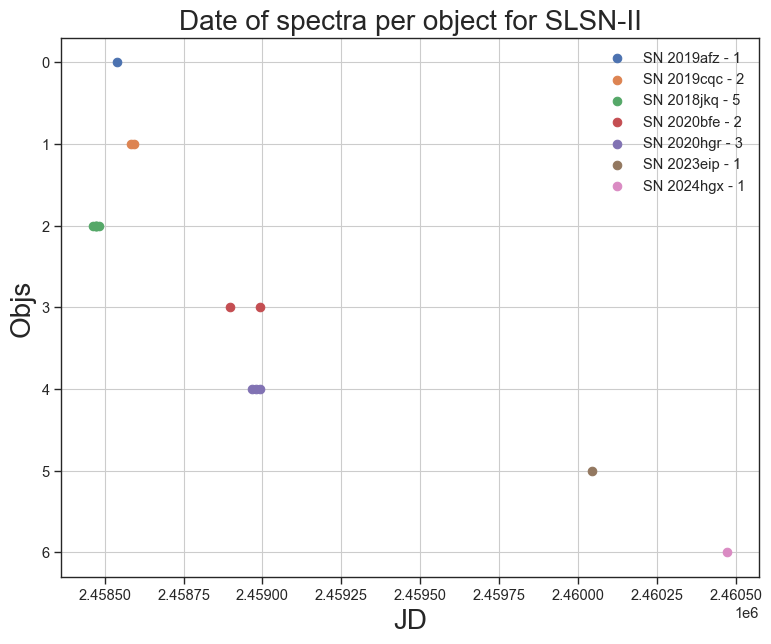

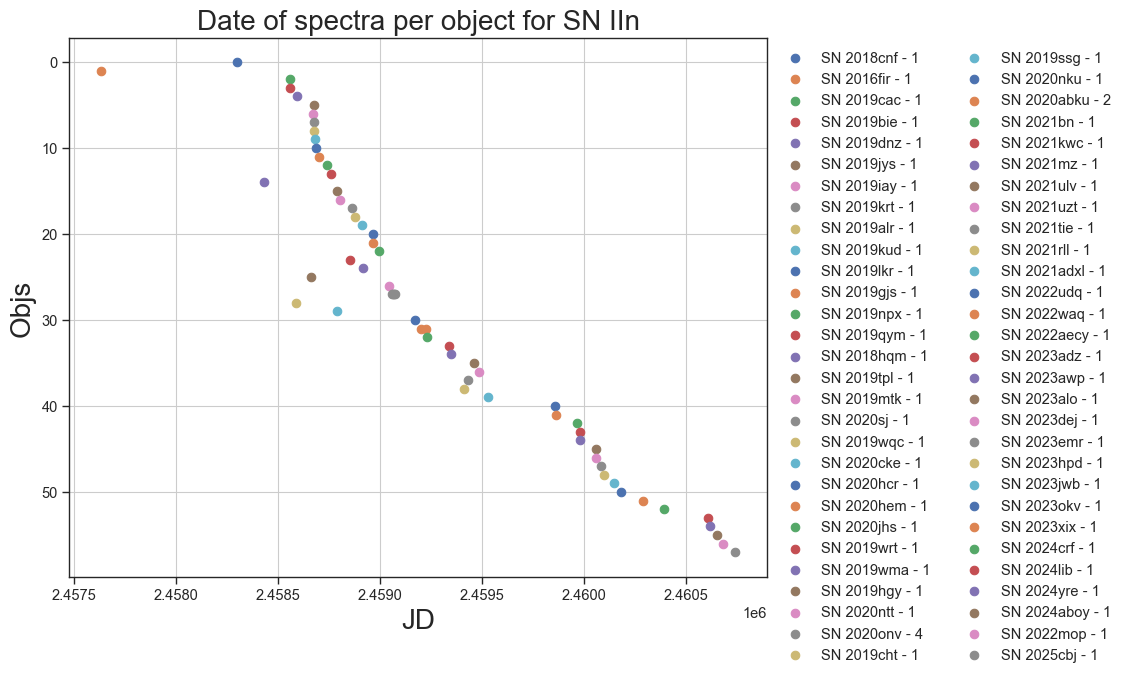

In [ ]:
types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I', 'SLSN-II', 'SN IIn']
types_flags = [iib, ib, ic, slsni, slsnii, iin]

for i,types in enumerate(types_flags):
    objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of SN names

    plt.figure(figsize=(9,7))
    plt.xlabel('JD', fontsize=20)
    plt.ylabel('Objs', fontsize=20)
    plt.title(f'Date of spectra per object for {types_str[i]}', fontsize=20)

    for j in range(len(objs)):
        jds = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'JD'].array #JD of spectra taken for individ obj
        plt.scatter(jds, [j]*len(jds), marker='.', s=150, label=f'{objs[j]} - {len(jds)}')

    if len(objs)>26:
        plt.legend(bbox_to_anchor=(1,1.0), frameon=False, ncol=2)
    else:
        plt.legend(bbox_to_anchor=(1,1.0), frameon=False, ncol=1)
    plt.gca().invert_yaxis()

    plt.savefig(f'./figures/num_spec_for_{types_str[i]}.png', bbox_inches='tight')

In [127]:
# pd.set_option('display.max_rows', 50)

In [128]:
#read in all peak info files
#creates temp peak_mag df that drops repeated SN, keeps most updated SN/fit
# peak_mag is then concat'd to mp_spec_df

peak_files = glob.glob('./ztf_fp_data/peak_fit_*.txt')

peak_df = pd.DataFrame()
for file in peak_files:
    colnames = ['IAU name', 'peak_mjd', 'peak_mag', 'peak_filt']
    df = pd.read_csv(file, header=None, names=colnames, sep=' ', skiprows=1)
    df['IAU name'] = 'SN '+df['IAU name'] #adding SN to match IAU standard in larger df 

    # if verbose:
    #     print(df.loc[df['sn_name'].duplicated(), 'sn_name']) # names of objects that were duplicated
    df = df.drop_duplicates(subset=['IAU name'], keep='last', ignore_index=True) #only keep repeated names w/ highest index

    peak_df = pd.concat([peak_df,df],axis=0,ignore_index=True)

mp_spec_df = pd.merge(mp_spec_df, peak_df, on='IAU name', how='outer')

In [ ]:
mp_spec_df['Phase (days)'] = mp_spec_df['mjd'] - mp_spec_df['peak_mjd']

In [164]:
mp_spec_df = mp_spec_df.loc[mp_spec_df['peak_mag'].notna()].reset_index(drop=True)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_74421/614774582.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


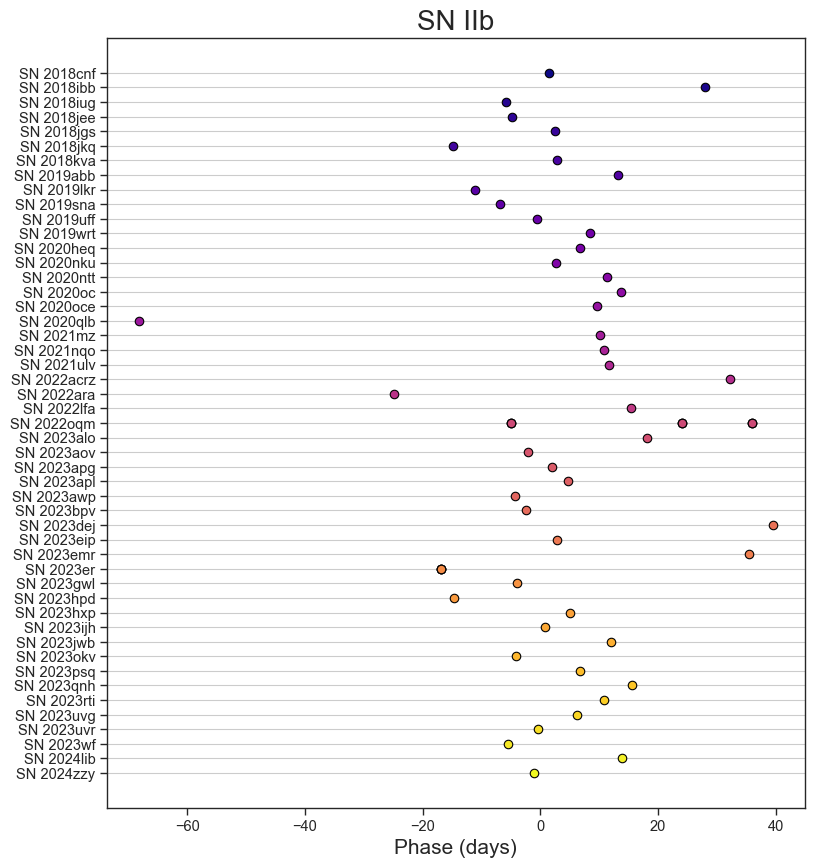

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_74421/614774582.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


<Figure size 640x480 with 0 Axes>

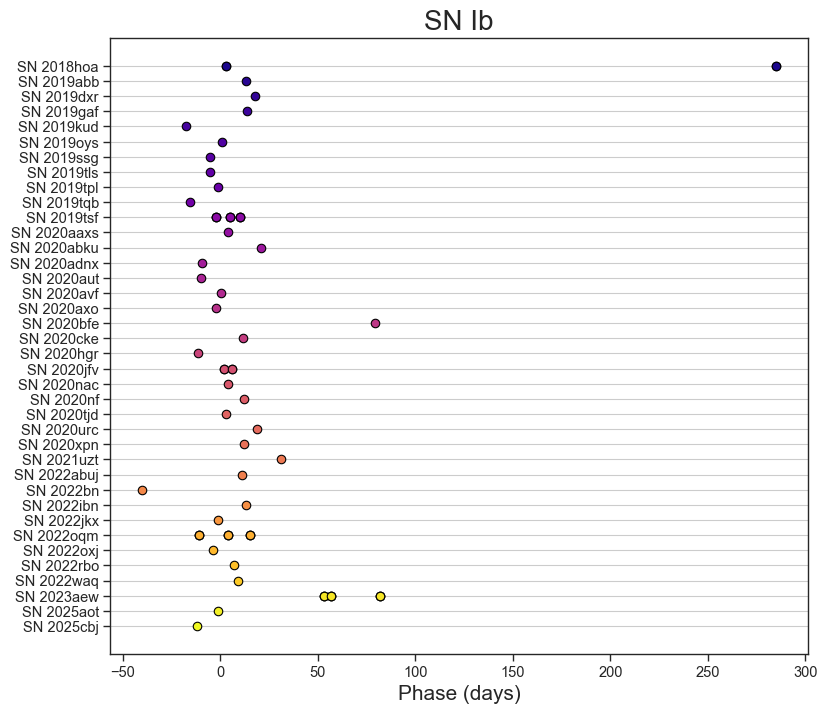

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_74421/614774582.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


<Figure size 640x480 with 0 Axes>

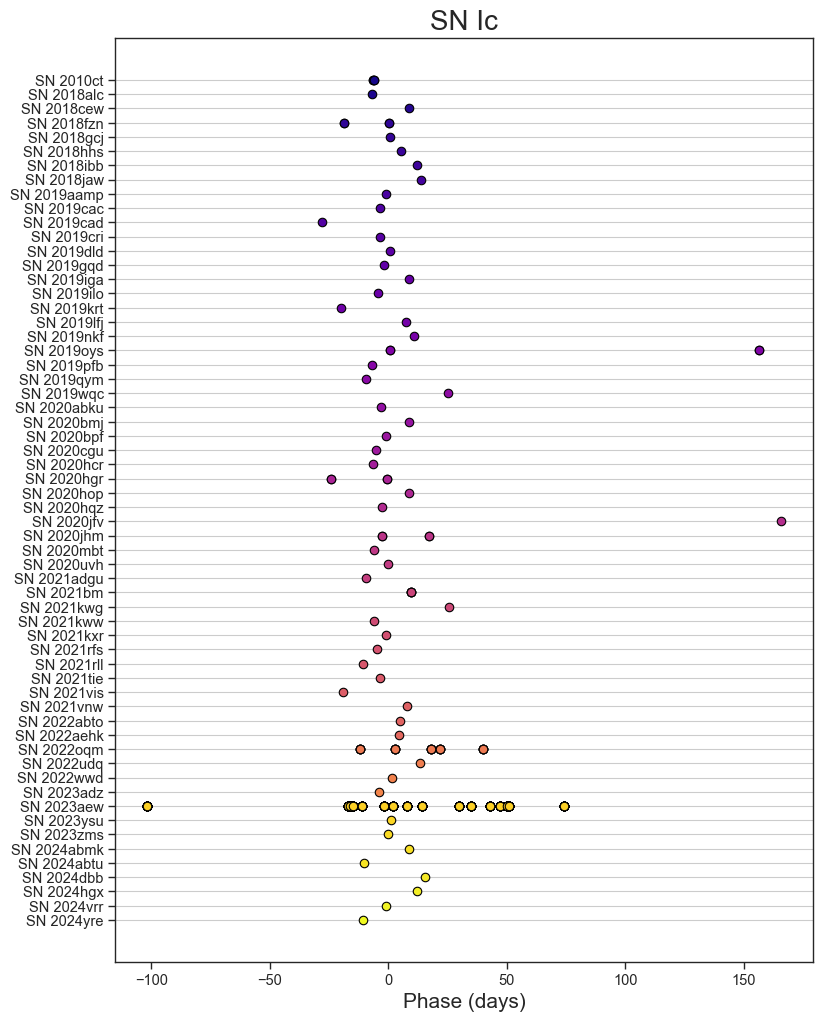

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_74421/614774582.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


<Figure size 640x480 with 0 Axes>

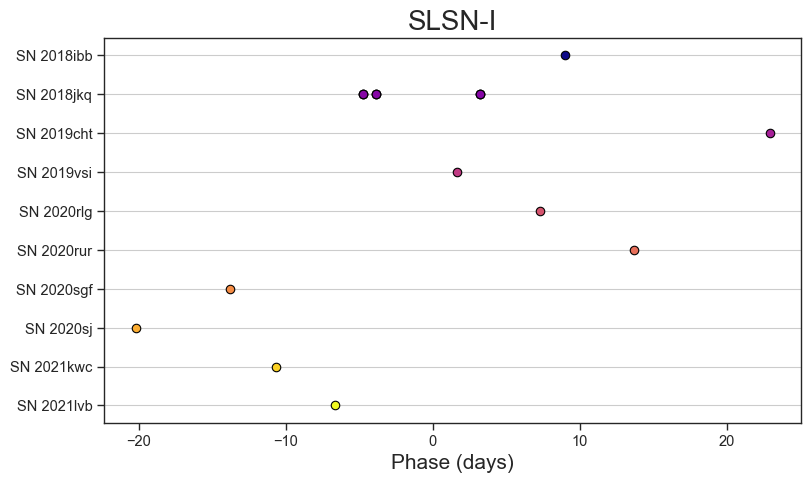

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_74421/614774582.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


<Figure size 640x480 with 0 Axes>

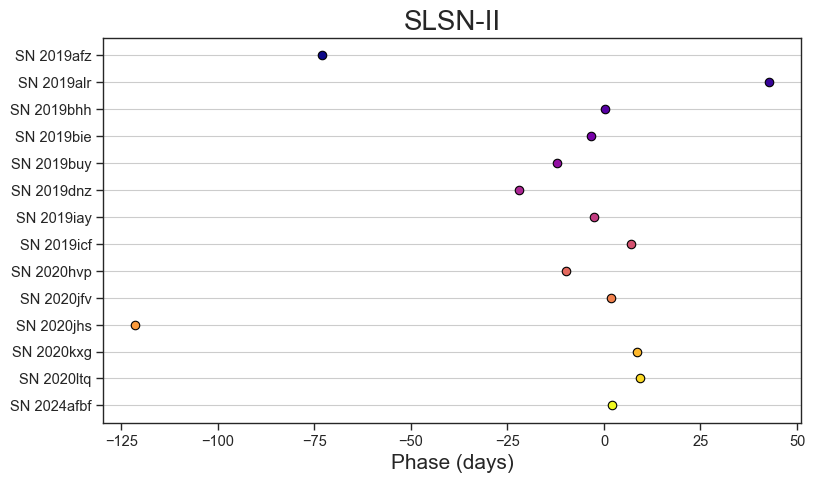

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_74421/614774582.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('plasma', len(sn_names))


<Figure size 640x480 with 0 Axes>

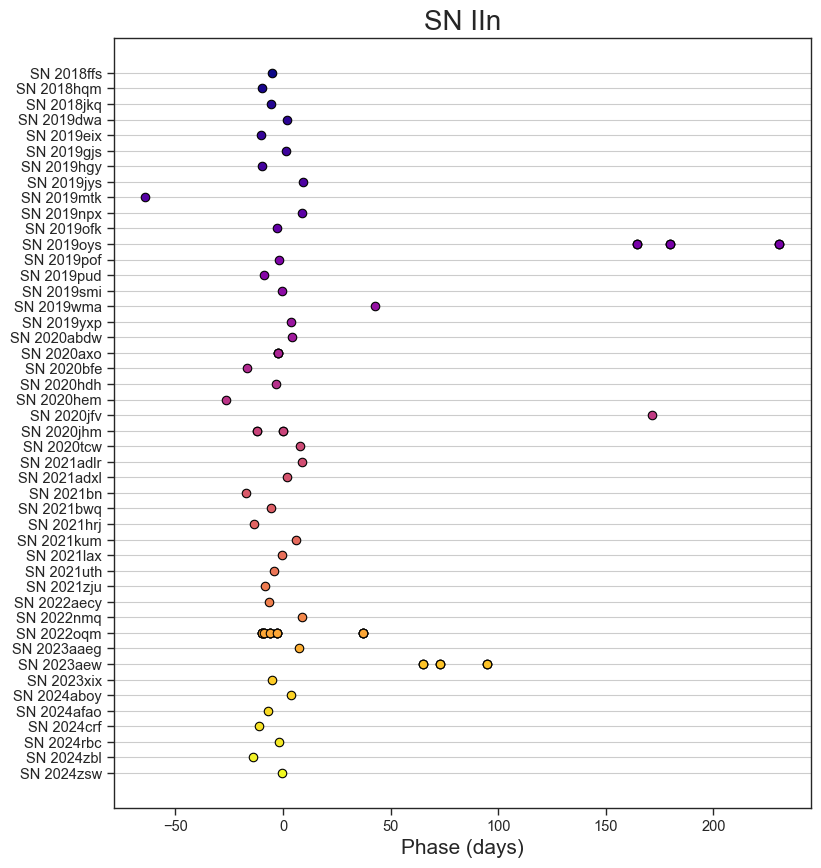

<Figure size 640x480 with 0 Axes>

In [240]:
types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I', 'SLSN-II', 'SN IIn']
types_flags = [iib, ib, ic, slsni, slsnii, iin]

for i,types in enumerate(types_flags):
    if len(mp_spec_df.loc[types, 'IAU name'])<20:
        ylen = 5
    elif len(mp_spec_df.loc[types, 'IAU name'])<50:
        ylen = 8
    elif len(mp_spec_df.loc[types, 'IAU name'])<75:
        ylen = 10
    elif len(mp_spec_df.loc[types, 'IAU name'])<100:
        ylen= 12

    fig = plt.figure(figsize=(9,ylen))
    ax1 = fig.add_subplot(111)

    sn_names = mp_spec_df.loc[types, 'IAU name'].tolist()
    viridis = cm.get_cmap('plasma', len(sn_names))
    test = [mpl.colors.to_hex(viridis.colors[i]) for i in range(len(sn_names))]
    # colors = [cm.to_hex(plt.cm.jet(i)) for i in range(len(sn_names))]
    sn_colors = dict(zip(sn_names,test))

    for j,sn in enumerate(sn_names):
        ax1.scatter(mp_spec_df.loc[types&(mp_spec_df['IAU name']==sn), 'Phase (days)'],
                    mp_spec_df.loc[types&(mp_spec_df['IAU name']==sn), 'IAU name'],
                    marker='.', s=150, edgecolor='black', facecolor=sn_colors.get(sn,'k'))
    
    ax1.set_xlabel('Phase (days)', fontsize=15)

    # ax2 = ax1.twiny()
    # ax2.scatter(mp_spec_df.loc[types, 'Phase (days)'], mp_spec_df.loc[types, 'IAU name'], marker='.', s=150)
    # ax2.set_xlabel('MJD fontsize=15)

    plt.gca().invert_yaxis()
    plt.gca().xaxis.grid(False)
    plt.gca().yaxis.grid(True)

    plt.title(f'{types_str[i]}', fontsize=20)
    plt.show()

    plt.savefig(f'./figures/phase_of_spec_for_{types_str[i]}.png', bbox_inches='tight')